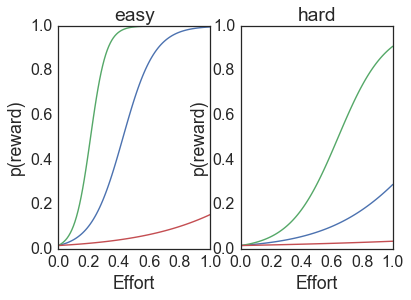

In [971]:
import pandas as pd
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

N_samples = 10000
threshold = .5
REWARD = 1

COST = 0.5
# 6 / 60
B=6
A=60 # 40 # 60
u_skill = .625
tao_skill = 20

def prob_reward(e,diff,skill):
    return 1/(1 + A * np.exp(-(e * skill / diff) * B)) 

def get_effort(reward, cost, diff, skill):
    Us=list()
    es = np.linspace(0, 1, 100) 
    for i in es:
        U=reward*prob_reward(i, diff, skill)-cost*i #utility function
        Us.append(U)
    return es[np.argmax(Us)], Us, es  #return argmax of utility, and utilities 

unskilled = .4
skilled = .8
kid = .1
easy = .25
hard = .75
es=np.linspace(0,1,100)
p0 = [prob_reward(e,easy,unskilled) for e in es]
p1 = [prob_reward(e,easy,skilled) for e in es]
p2 = [prob_reward(e,easy,kid) for e in es]

plt.subplot(1,2,1)
plt.plot(es,p0, es, p1, es, p2)
plt.ylim([0,1])
plt.xlabel('Effort') ; plt.ylabel('p(reward)'); plt.title('easy')

p0 = [prob_reward(e,hard,unskilled) for e in es]
p1 = [prob_reward(e,hard,skilled) for e in es]
p2 = [prob_reward(e,hard,kid) for e in es]
plt.subplot(1,2,2)
plt.plot(es,p0, es, p1, es, p2)
plt.ylim([0,1])
plt.xlabel('Effort') ; plt.ylabel('p(reward)'); plt.title('hard')

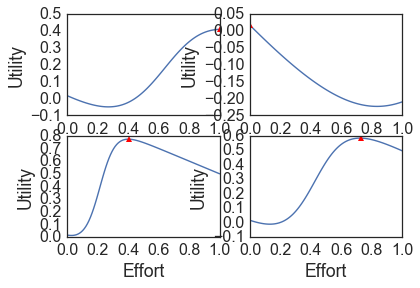

In [972]:


plt.subplot(2,2,1)
effort,Us,es=get_effort(REWARD,COST,hard,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')

plt.subplot(2,2,2)
effort,Us,es=get_effort(REWARD,COST,hard,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')

plt.subplot(2,2,3)
effort,Us,es=get_effort(REWARD,COST,easy,skilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')

plt.subplot(2,2,4)
effort,Us,es=get_effort(REWARD,COST,easy,unskilled) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Effort')
plt.ylabel('Utility')

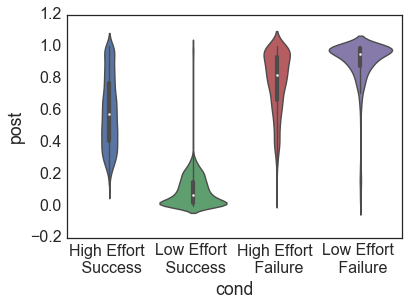

In [973]:
#MAKE INTO DIC
sampled_skill_high = list()
sampled_diff_high = list()
sampled_skill_low = list()
sampled_diff_low = list()
sampled_skill_low_fail=list()
sampled_diff_low_fail=list()
sampled_skill_high_fail=list()
sampled_diff_high_fail=list()
diff_samp=list()
skill_samp=list()
effort_samp=list()
succes_samp=list()
for _ in xrange(N_samples):
    skill = np.random.beta(tao_skill*u_skill,(1-u_skill)*tao_skill) #skill is a beta function
    diff = np.random.beta(.5,.5) #difficulty is a beta function
    effort,_,_ = get_effort(REWARD, COST, diff, skill) 

    high_effort = effort > threshold
    success = prob_reward(effort,diff,skill) > np.random.random()

    diff_samp.append(diff)
    skill_samp.append(skill)
    effort_samp.append(effort)
    succes_samp.append(success)
    if success and high_effort: 
        sampled_skill_high.append(skill)
        sampled_diff_high.append(diff)
    elif success and not high_effort: 
        sampled_skill_low.append(skill)
        sampled_diff_low.append(diff)
    elif not success and not high_effort: 
        sampled_skill_low_fail.append(skill)
        sampled_diff_low_fail.append(diff)
    elif not success and high_effort: 
        sampled_skill_high_fail.append(skill)
        sampled_diff_high_fail.append(diff)

df = pd.DataFrame([{'cond': 'High Effort \n Success', 'post': s} for s in sampled_diff_high] +  
                  [{'cond': 'Low Effort \n Success', 'post': s} for s in sampled_diff_low] +      
                  [{'cond': 'High Effort \n Failure', 'post': s} for s in sampled_diff_high_fail] +      
                  [{'cond': 'Low Effort \n Failure', 'post': s} for s in sampled_diff_low_fail])     

sns.violinplot('cond', 'post', data = df)

In [974]:
def get_your_effort(reward, cost, diff):  #model for planning. Takes in diff, skill, and cost -returns effort
    sampled_effort= list()
    sampled_skill=list()
    for i in xrange(N_samples):
        s = np.random.rand()
        d = np.random.choice(diff)
        effort,_,_= get_effort(reward, cost, d, s) #noise on d
        sampled_effort.append(effort)
        sampled_skill.append(s)
    
    return sampled_effort, sampled_skill

effort_high_success,skill_high_success = get_your_effort(REWARD,COST,sampled_diff_high) 
effort_low_success,skill_low_success = get_your_effort(REWARD,COST,sampled_diff_low) 
effort_high_fail,skill_high_fail = get_your_effort(REWARD,COST,sampled_diff_high_fail)
effort_low_fail,skill_low_fail = get_your_effort(REWARD,COST,sampled_diff_low_fail)

(0.1, 0.7)

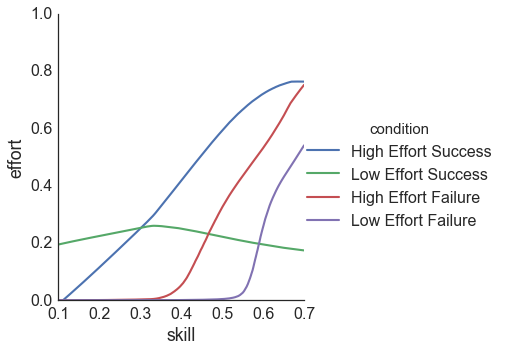

In [975]:
df = []
for s, e in zip(skill_high_success, effort_high_success):
    df.append({
            'skill':s,
            'effort':e,
            'condition':'High Effort Success'
        })

for s, e in zip(skill_low_success, effort_low_success):
    df.append({
            'skill':s,
            'effort':e,
            'condition':'Low Effort Success'
        })
    
for s, e in zip(skill_high_fail, effort_high_fail):
    df.append({
            'skill':s,
            'effort':e,
            'condition':'High Effort Failure'
        })
    
for s, e in zip(skill_low_fail, effort_low_fail):
    df.append({
            'skill':s,
            'effort':e,
            'condition':'Low Effort Failure'
        })
    
df = pd.DataFrame(df)

sns.lmplot(x="skill", y="effort", hue="condition", scatter=False, ci=None, data=df, lowess=True)
plt.ylim([0,1])
plt.xlim([.10,.70])

In [976]:
def your_eff_know_skill(reward, cost, diff,skill):  #model for planning. Takes in diff, skill, and cost -returns effort
    sampled_effort= list()
    sampled_skill=list()
    for i in xrange(N_samples):
        d = np.random.choice(diff)
        effort,_,_=get_effort(reward, cost, d, skill)
        sampled_effort.append(effort)
        sampled_skill.append(skill)
    
    return sampled_effort

In [977]:
skill=.4

effort_high_success = your_eff_know_skill(REWARD, COST, sampled_diff_high,skill) 
effort_low_success = your_eff_know_skill(REWARD, COST, sampled_diff_low,skill) 
effort_high_fail = your_eff_know_skill(REWARD, COST, sampled_diff_high_fail,skill) 
effort_low_fail = your_eff_know_skill(REWARD, COST, sampled_diff_low_fail,skill) 
effort_baseline = your_eff_know_skill(REWARD, COST, np.random.beta(tao_skill*u_skill,(1-u_skill)*tao_skill, size=1000),skill) 


print np.mean(effort_high_success)
print np.mean(effort_low_success)
print np.mean(effort_high_fail)
print np.mean(effort_low_fail)
print np.mean(effort_baseline)

0.475192929293
0.280981818182
0.157991919192
0.017595959596
0.31986969697


In [978]:
scale = 200
print np.mean(effort_high_success)*scale
print np.mean(effort_low_success)*scale
print np.mean(effort_high_fail)*scale
print np.mean(effort_low_fail)*scale

df = pd.DataFrame([{'cond': 'High Effort \n Success', 'post': s*scale} for s in effort_high_success] +  
                  [{'cond': 'Low Effort \n Success', 'post': s*scale} for s in effort_low_success] +      
                  [{'cond': 'High Effort \n Failure', 'post': s*scale} for s in effort_high_fail] +      
                  [{'cond': 'Low Effort \n Failure', 'post': s*scale} for s in effort_low_fail] + 
                  [{'cond': 'Baseline', 'post': s*scale} for s in effort_baseline])     

# sns.boxplot('cond', 'post', data = df)

d = {'Model' : pd.Series([np.mean(effort_high_success)*scale, np.mean(effort_low_success)*scale, np.mean(effort_high_fail)*scale, np.mean(effort_low_fail)*scale], index=['High Effort Success', 'Low Effort Success', 'High Effort Failure', 'Low Effort Failure']),
     'Human' : pd.Series([107, 57, 30, 35], index=['High Effort Success', 'Low Effort Success', 'High Effort Failure', 'Low Effort Failure'])}

df = pd.DataFrame(d)
df

95.0385858586
56.1963636364
31.5983838384
3.51919191919


,Human,Model
High Effort Success,107,95.038586
Low Effort Success,57,56.196364
High Effort Failure,30,31.598384
Low Effort Failure,35,3.519192
